Cargamos las librerías, el conjunto de datos y algunas variables que emplearemos durante el proceso:

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./processed_data/houses_integrated.csv')

# Ampliamos el límite de columnas visibles para poder visualizarlas todas
pd.set_option('display.max_columns', 500)

# Definimos un listado de colores para visualizaciones
clr = {'pr':'#5F66A1', 'yw':'#f3ca75', 'mg':'#c874b9', 'gn': '#599d70', 'br': '#636261'}

# Omitimos los warnings
import warnings
warnings.filterwarnings('ignore')

# Verificación de los datos

En esta fase verificaremos la calidad de los datos por medio de una serie de procesos.

## Descarte de las casas de alquiler

En el conjunto de datos que disponemos, se mezclan anuncios con casa en venta y alquiler. Este análisis se centra en la venta de casas, por lo tanto, los anuncios ligados al alquilern han de descartarse.

No obstante, no hay ningún campo que permita esta división de forma directa. Por ello, se opta por emplear el precio para esta tarea, ya que, en principio, la venta y el alquiler de casas han de tener precios muy distintos.

Analizemos por lo tanto los precios por medio de un histograma que nos muestre los precios entre 2.500€ y 30.000€ para ver a partir de qué precio intuímos que podemos considerar que una casa está en venta y no en alquiler:

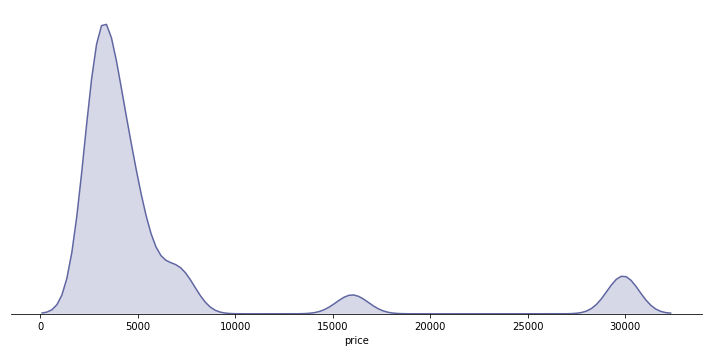

In [2]:
f, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
sns.despine(left=True)

(df['price']
 .pipe(sns.distplot, hist=False, color=clr['pr'], kde_kws={"shade": True, 'clip': (2500, 30000)}))

plt.setp(axes, yticks=[])
plt.tight_layout()

Vemos que hay algunas casas con precios entre 10.000€ y 20.000€ con los que hay cierta ambiguedad, ya que si bien es un precio de venta muy muy bajo, como precio de alquiler mensual es excesivo.

No obstante, en vista de que no son muchos, se opta por descartar todas las casas por debajo de los 30.000€.

In [3]:
h_num = df[df.price < 30000].shape[0]
df = df[df.price > 30000]
print(f'Se han descartado {h_num} casas de alquiler del dataset')

Se han descartado 1703 casas de alquiler del dataset


## Verificación de casas duplicadas

Puede que haya casas duplicadas en nuestro conjunto de datos. Cada anuncio de casa se define mediante un identificador único. Por ello, la forma más sencilla para verificar que no haya 2 anuncios repetidos es comprobando ese identificador:

In [4]:
h_num = df[df.house_id.duplicated()].shape[0]
df.drop_duplicates(subset='house_id', inplace=True)
print(f'Se han descartado {h_num} casas duplicadas del dataset')

Se han descartado 5020 casas duplicadas del dataset


# Estandarización de variables

En este apartado se procede a estandarizar las variables, corrigiendo su tipo, y normalizando sus valores, (entendiendo por normalizar, asignarles el valor más representativo).

*NOTA: En este apartado no se tratarán ni los missing values ni los outliers. Su gestión se deja para más adelante.*

## Estudio de variables a estandarizar

Empezaremos analizando cómo han sido asignadas las variables:

In [5]:
df.dtypes

house_id               int64
ad_description        object
price                  int64
bath_num              object
condition             object
construct_date       float64
energetic_certif      object
floor                 object
ground_size          float64
heating               object
house_type            object
m2_real                int64
m2_useful            float64
orientation           object
room_num              object
air_conditioner        int64
balcony                int64
built_in_wardrobe      int64
chimney                int64
garage                object
garden                 int64
kitchen              float64
lift                 float64
reduced_mobility       int64
storage_room           int64
swimming_pool          int64
terrace                int64
unfurnished          float64
loc_zone              object
loc_district          object
loc_city              object
loc_neigh             object
pop_total            float64
pop_0-19               int64
pop_20-64     

De la lista superior, extraemos qué variables estudiaremos en la estandarización. En concreto, nos centraremos en 4 grupos: 
+ Por un lado estandarizaremos las variables numéricas que no hayan asignado como tal
+ Por otro lado, estudiaremos las variables categóricas
+ A continuación estudiaremos las variables categoricas binarias, es decir, booleanas
+ Finalmente, nos centraremos en las variables de texto ligadas a la ubicación

<br />

**VARIABLES NUMÉRICAS NO ASIGNADAS COMO TAL**

+ <font color=#5F66A1>*bath_num*<font>
+ <font color=#5F66A1>*room_num*<font>
+ <font color=#5F66A1>*garage*<font>


**VARIABLES CATEGÓRICAS**

+ <font color=#5F66A1>*condition*<font>
+ <font color=#5F66A1>*energetic_certif*<font>
+ <font color=#5F66A1>*floor*<font>
+ <font color=#5F66A1>*heating*<font>
+ <font color=#5F66A1>*house_type*<font>
+ <font color=#5F66A1>*orientation*<font>


**VARIABLES BOOLEANAS**

+ <font color=#5F66A1>*air_conditioner*<font>
+ <font color=#5F66A1>*balcony*<font>
+ <font color=#5F66A1>*built_in_wardrobe*<font>
+ <font color=#5F66A1>*chimney*<font>
+ <font color=#5F66A1>*garden*<font>
+ <font color=#5F66A1>*kitchen*<font>
+ <font color=#5F66A1>*lift*<font>
+ <font color=#5F66A1>*reduced_mobility*<font>
+ <font color=#5F66A1>*storage_room*<font>
+ <font color=#5F66A1>*swimming_pool*<font>
+ <font color=#5F66A1>*terrace*<font>
+ <font color=#5F66A1>*unfurnished*<font>


**VARIABLES DE TEXTO LIGADAS A LA UBICACIÓN**

+ <font color=#5F66A1>*loc_zone*<font>
+ <font color=#5F66A1>*loc_district*<font>
+ <font color=#5F66A1>*loc_city*<font>
+ <font color=#5F66A1>*loc_neigh*<font>

## Estandarización de variables numéricas

### <font color=#5F66A1>bath_num</font>

In [6]:
print(df.bath_num.unique())

['4' '1' '2' 'sin baños' '3' '9' '5' '6' '17' '8' '7' '10' '11' '15' '12']


Vemos como la ausencia de baños se identifica como 'sin baños', en forma de texto. Lo corregimos, y definimos la variable como numérica:

In [7]:
df['bath_num'] = (df['bath_num']
                  .str.replace('sin baños','0')
                  .astype('int64')
                 )

### <font color=#5F66A1>room_num</font>

In [8]:
print(df.room_num.unique())

['3' '2' '4' '8' '6' '5' '1' '9' '7' '11' 'sin habitación' '12' '20' '10'
 '14' '17' '34' '13']


Aquí tambien la ausencia de habitaciones se identifica en forma de texto, como 'sin habitación'. Lo corregimos, y definimos la variable como numérica:

In [9]:
df['room_num'] = (df['room_num']
                   .str.replace('sin habitación','0')
                   .astype('int64')
                  )

### <font color=#5F66A1>garage</font>

In [10]:
print(df.garage.unique())

['plaza de garaje incluida en el precio' nan
 'plaza de garaje por 9.500 eur adicionales'
 'plaza de garaje por 16.000 eur adicionales'
 'plaza de garaje por 20.000 eur adicionales'
 'plaza de garaje por 111 eur adicionales'
 'plaza de garaje por 25.000 eur adicionales'
 'plaza de garaje por 33.000 eur adicionales'
 'plaza de garaje por 22.000 eur adicionales'
 'plaza de garaje por 30.000 eur adicionales'
 'plaza de garaje por 15.000 eur adicionales'
 'plaza de garaje por 24.451 eur adicionales'
 'plaza de garaje por 24.452 eur adicionales'
 'plaza de garaje por 50.000 eur adicionales'
 'plaza de garaje por 14.900 eur adicionales'
 'plaza de garaje por 19.900 eur adicionales'
 'plaza de garaje por 35.000 eur adicionales'
 'plaza de garaje por 400.000 eur adicionales'
 'plaza de garaje por 12.000 eur adicionales'
 'plaza de garaje por 40.000 eur adicionales'
 'plaza de garaje por 242.000 eur adicionales'
 'plaza de garaje por 24.000 eur adicionales'
 'plaza de garaje por 0 eur adicional

Vemos que la variable refleja el precio de la plaza de garaje en forma de texto. Por lo tanto, extraemos el precio del texto y establecemos que la variable sea numérica:

In [11]:
df['garage'] = (df['garage']
                .str.replace('plaza de garaje incluida en el precio','0')
                .str.replace('.','')
                .str.extract('(\d{1,4})')
                .astype('float64')
               )

print(df.garage.unique())

[0.000e+00       nan 9.500e+03 1.600e+03 2.000e+03 1.110e+02 2.500e+03
 3.300e+03 2.200e+03 3.000e+03 1.500e+03 2.445e+03 5.000e+03 1.490e+03
 1.990e+03 3.500e+03 4.000e+03 1.200e+03 2.420e+03 2.400e+03 2.050e+03
 3.100e+03 2.100e+03 3.600e+03 3.200e+03 2.710e+03 3.150e+03 8.000e+01
 1.250e+03 1.900e+03 6.800e+03 6.500e+03 1.000e+00 4.500e+03 1.700e+03
 9.000e+03 8.000e+03 2.350e+03 1.000e+03 1.070e+03 1.010e+03 1.650e+03
 1.800e+03 2.600e+03 2.650e+03 2.800e+03 6.000e+03 2.300e+03 1.000e+02
 7.200e+03 5.168e+03 1.300e+03 4.300e+03 5.600e+03 1.050e+03 7.100e+03
 5.400e+03 4.660e+03 4.700e+03 9.900e+03 1.400e+03 4.250e+03 4.200e+03
 4.800e+03 1.620e+03 2.312e+03 1.780e+03 3.800e+03 2.900e+03 7.000e+03
 7.000e+01]


## Estandarización de variables categóricas

### <font color=#5F66A1>condition</font>

In [12]:
print(df.condition.unique())

['segunda mano/buen estado' nan 'segunda mano/para reformar'
 'promoción de obra nueva']


Vemos que hay 3 posibles categorías. Redefinimos los nombres de las categorías para mejorar su interpretabilidad.

In [13]:
df = df.replace({'condition':
                 {
                  'segunda mano/buen estado':'buen estado',
                  'segunda mano/para reformar':'para reformar',
                  'promoción de obra nueva':'obra nueva'
                 }})

df['condition'] = df['condition'].astype('category')

### <font color=#5F66A1>energetic_certif</font>

In [14]:
print(df.energetic_certif.unique())

['en trámite' nan 'no indicado' 'inmueble exento']


No requiere ningun tratamiento salvo definirla como categórica:

In [15]:
df['energetic_certif'] = df['energetic_certif'].astype('category')

### <font color=#5F66A1>floor</font>

In [16]:
print(df.floor.unique())

['3 plantas' 'planta 5ª exterior' nan '2 plantas' 'planta 4ª exterior'
 'planta 2ª exterior' 'planta 1ª' 'planta 4ª' 'entreplanta exterior'
 'planta 3ª exterior' 'planta 1ª exterior' 'bajo exterior' 'planta 3ª'
 '4 plantas' 'planta 8ª exterior' 'planta 2ª interior' 'bajo' 'planta 5ª'
 'planta 2ª' '1 planta' 'planta 6ª exterior' '5 plantas' 'exterior'
 'entreplanta' 'semi-sótano exterior' 'planta 1ª interior'
 'planta 7ª exterior' 'planta 10ª exterior' 'planta 9ª exterior'
 'planta 3ª interior' 'planta -2 exterior' 'planta 6ª' 'planta 7ª'
 'planta 4ª interior' 'sótano exterior' 'planta 12ª exterior'
 'planta 60ª exterior' 'planta -1 exterior' 'interior'
 'planta 5ª interior' 'planta 11ª exterior' 'bajo interior' 'planta 9ª'
 'planta 7ª interior' 'planta 16ª exterior' 'planta 10ª'
 'planta 14ª exterior' 'planta 15ª exterior' 'planta 6ª interior'
 'planta 13ª exterior' 'planta 8ª' 'planta 20ª exterior'
 'planta 19ª exterior' 'sótano interior' 'entreplanta interior'
 'planta 8ª interior' '

Vemos que, a grandes rasgos, esta variable esconde lo que podrían ser 3 variables distintas:

+ Número de planta en la que se encuentra el domicilio
+ Indicador de si la planta está en el interior o en el exterior
+ Número de plantas de las que consta el domicilio

Por lo tanto, se procede a dividir la variable en 3. 

<br />

Empezamos generando la variable booleana <font color=#5F66A1>__indoor__</font>, que tomará el valor True si el domicilio está en el interior, y False en el caso contrario:

In [17]:
df['indoor'] = (df['floor']
                .str.contains('interior')
                .astype('category')   # no se define como bool porque aún contiene NaN
               )

print(df['indoor'].unique())

[False, NaN, True]
Categories (2, object): [False, True]


<br />

A continuación crearemos la variable <font color=#5F66A1>__floor_count__</font>, que recogerá el número de plantas de las que consta la casa.

Para ello, empezamos asignando como valor 1 a todas las casas que tengan información sobre la planta (las que estan como NaN las dejaremos por ahora tal cual, puesto que no tenemos información al respecto)

In [18]:
df['floor_count'] = np.nan
df['floor_count'][df.floor.notnull()] = 1
df['floor_count'].head(5)

0    1.0
1    1.0
2    NaN
3    NaN
4    NaN
Name: floor_count, dtype: float64

A continuación, añadiremos la información sobre las casas con más de una planta. Para ello, seleccionaremos todas las celdas que contengan la palabra 'plantas' (en plural), y de allí extraeremos el número por medio de una expresión regular:

In [19]:
f_c = (df['floor'][df.floor.str.contains('plantas', na=False)]
       .str.extract('(\d+)')
       .astype('float64')
       .rename(columns={0:'floor_count'})
      )
       
f_c['floor_count'].head(5)

0     3.0
5     3.0
10    2.0
15    3.0
21    2.0
Name: floor_count, dtype: float64

Una vez hemos extraído el número de plantas de las casas con más de una, actualizamos la variable:

In [20]:
df.update(f_c)
print(df.floor_count.unique())

[ 3.  1. nan  2.  4.  5.]


<br />

Por último modificaremos la variable <font color=#5F66A1>__floor__</font>, para que solo recoja el número de planta en el que se encuentra el piso:

In [21]:
df['floor'] = (df['floor']
               .str.replace('exterior', '')
               .str.replace('interior', '')
               .str.replace('1 planta', '')
               .str.replace('(\d+) plantas', '')
               .str.strip()
               .str.replace('planta ', '')
               .str.replace('-1', '-1ª')
               .str.replace('-2', '-2ª')
               .replace('', np.nan)
               .astype('category')
              )

print(df.floor.unique())

[NaN, 5ª, 4ª, 2ª, 1ª, ..., 20ª, 19ª, 18ª, 21ª, 24ª]
Length: 29
Categories (28, object): [5ª, 4ª, 2ª, 1ª, ..., 19ª, 18ª, 21ª, 24ª]


### <font color=#5F66A1>heating</font>

In [22]:
print(df.heating.unique())

[nan 'calefacción individual' 'calefacción individual: gas natural'
 'calefacción central: gasoil' 'calefacción central: gas'
 'calefacción individual: eléctrica'
 'calefacción individual: gas propano/butano'
 'calefacción central: gas propano/butano' 'calefacción central'
 'calefacción individual: gas' 'calefacción central: gas natural'
 'no dispone de calefacción' 'calefacción individual: bomba de frío/calor'
 'no dispone de calefacción: gas propano/butano'
 'calefacción individual: gasoil']


Sustraemos la palabra 'calefacción' para mayor interpretabilidad, y la definimos como categórica:

In [23]:
df['heating'] = (df['heating']
                 .str.replace('calefacción ', '')
                 .astype('category')
                )

### <font color=#5F66A1>house_type</font>

In [24]:
print(df.house_type.unique())

[' Casa o chalet independiente' 'Piso' ' Casa o chalet' 'Casa rural'
 ' Caserón' ' Chalet adosado' ' Casa rural' ' Casa de pueblo' ' Palacio'
 'Dúplex' ' Finca rústica' 'Ático' 'Estudio' ' Chalet pareado'
 ' Casa terrera' ' Castillo' ' Cortijo' ' Torre']


Eliminamos los espacios en blanco y la definimos como categórica:

In [25]:
df['house_type'] = (df['house_type']
                    .str.strip()
                    .astype('category')
                   )

### <font color=#5F66A1>orientation</font>

In [26]:
print(df.orientation.unique())

[nan 'sur, este' 'sur' 'este, oeste' 'norte, este'
 'norte, sur, este, oeste' 'norte, sur, este' 'sur, oeste'
 'norte, este, oeste' 'norte' 'norte, sur' 'oeste' 'sur, este, oeste'
 'este' 'norte, sur, oeste' 'norte, oeste']


No requiere estandarización salvo definirla como categórica:

In [27]:
df['orientation'] = (df['orientation'].astype('category'))

## Estandarización de variables booleanas

Analizamos qué valores tienen las variables booleanas:

In [28]:
print(f'Valores para air_conditioner: {df.air_conditioner.unique()}')
print(f'Valores para balcony: {df.balcony.unique()}')
print(f'Valores para built_in_wardrobe: {df.built_in_wardrobe.unique()}')
print(f'Valores para chimney: {df.chimney.unique()}')
print(f'Valores para garden: {df.garden.unique()}')
print(f'Valores para kitchen: {df.kitchen.unique()}')
print(f'Valores para lift: {df.lift.unique()}')
print(f'Valores para reduced_mobility: {df.reduced_mobility.unique()}')
print(f'Valores para storage_room: {df.storage_room.unique()}')
print(f'Valores para swimming_pool: {df.swimming_pool.unique()}')
print(f'Valores para terrace: {df.terrace.unique()}')
print(f'Valores para unfurnished: {df.unfurnished.unique()}')

Valores para air_conditioner: [0 1]
Valores para balcony: [1 0]
Valores para built_in_wardrobe: [1 0]
Valores para chimney: [0 1]
Valores para garden: [1 0]
Valores para kitchen: [nan]
Valores para lift: [nan  0.  1.]
Valores para reduced_mobility: [0 1]
Valores para storage_room: [1 0]
Valores para swimming_pool: [1 0]
Valores para terrace: [0 1]
Valores para unfurnished: [nan]


Por un lado  vemosque las variables *kitchen* y *unfurnished* solo contienen *nan*, probablemente porque se traten de variables ligadas exclusivamente a casas de alquiler. Por lo tanto, las eliminamos:

In [29]:
df = df.drop(columns=['kitchen', 'unfurnished'])

Por otra parte, vemos que la variable lift, a pesar de ser booleana, contiene valores nan, por lo que la definimos como categórica por ahora:

In [30]:
df['lift'] = df['lift'].astype('category')

Finalmente, el resto de variables categóricas las definimos como booleanas:

In [31]:
df['air_conditioner'] = df['air_conditioner'].astype('bool')
df['balcony'] = df['balcony'].astype('bool')
df['built_in_wardrobe'] = df['built_in_wardrobe'].astype('bool')
df['chimney'] = df['chimney'].astype('bool')
df['garden'] = df['garden'].astype('bool')
df['reduced_mobility'] = df['reduced_mobility'].astype('bool')
df['storage_room'] = df['storage_room'].astype('bool')
df['swimming_pool'] = df['swimming_pool'].astype('bool')
df['terrace'] = df['terrace'].astype('bool')

## Estandarización de variables ligadas a la ubicación

La localización de cada vivienda viene especificada por medio de 4 variables distintas, las cuales están organizadas de forma jerárquica del siguiente modo:

+ <font color=#5F66A1>__loc_zone__</font> &nbsp; > &nbsp;<font color=#5F66A1>__loc_city__</font> &nbsp;> &nbsp;<font color=#5F66A1>__loc_district__</font> &nbsp;> &nbsp;<font color=#5F66A1>__loc_neigh__</font>

### <font color=#5F66A1>loc_zone</font>

In [32]:
print(df.loc_zone.unique())

['Encartaciones, Vizcaya' 'Uribe-Butroe, Vizcaya' 'Lea-Artibai, Vizcaya'
 'Duranguesado, Vizcaya' 'Gran Bilbao, Vizcaya' 'Busturialdea, Vizcaya'
 'Arratia-Nervión, Vizcaya' 'Urola Kosta, Guipúzcoa' 'Goierri, Guipúzcoa'
 'Donostialdea, Guipúzcoa' 'Bajo Bidasoa, Guipúzcoa'
 'Alto Deba, Guipúzcoa' 'Bajo Deba, Guipúzcoa' 'Tolosaldea, Guipúzcoa']


Definimos las provincias con las iniciales y convertimos la variable en categórica:

In [33]:
df['loc_zone'] = (df['loc_zone']
                  .str.replace(', Vizcaya',' (BIZ)')
                  .str.replace(', Guipúzcoa',' (GIP)')
                  .astype('category')
                 )

print(df.loc_zone.unique())

[Encartaciones (BIZ), Uribe-Butroe (BIZ), Lea-Artibai (BIZ), Duranguesado (BIZ), Gran Bilbao (BIZ), ..., Donostialdea (GIP), Bajo Bidasoa (GIP), Alto Deba (GIP), Bajo Deba (GIP), Tolosaldea (GIP)]
Length: 14
Categories (14, object): [Encartaciones (BIZ), Uribe-Butroe (BIZ), Lea-Artibai (BIZ), Duranguesado (BIZ), ..., Bajo Bidasoa (GIP), Alto Deba (GIP), Bajo Deba (GIP), Tolosaldea (GIP)]


### <font color=#5F66A1>loc_city</font>

In [34]:
print(df.loc_city.unique())

['Gordexola' 'Artzentales' 'Sopuerta' 'Balmaseda'
 'Karrantza Harana/Valle de Carranza' 'Güeñes' 'Zalla' 'Lanestosa'
 'Galdames' 'Trucios-Turtzioz' 'Berango' 'Mungia' 'Urdúliz' 'Gorliz'
 'Plentzia' 'Bakio' 'Laukiz' 'Lemoiz' 'Maruri-Jatabe' 'Gatika' 'Barrika'
 'Arrieta' 'Fruiz' 'Meñaka' 'Gamiz-Fika' 'Berriatua' 'Lekeitio' 'Ondarroa'
 'Ziortza-Bolibar' 'Amoroto' 'Markina-Xemein'
 'Munitibar-Arbatzegi Gerrikaitz' 'Mendexa' 'Ispaster' 'Aulesti'
 'Etxebarria' 'Gizaburuaga' 'Zaldibar' 'Ermua' 'Amorebieta-Etxano'
 'Mañaria' 'Mallabia' 'Durango' 'Bérriz' 'Iurreta' 'Atxondo' 'Elorrio'
 'Abadiño' 'Garai' 'Izurtza' 'Lezama' 'Zamudio' 'Larrabetzu'
 'Valle de Trápaga-Trapagaran' 'Ortuella' 'Muskiz' 'Loiu' 'Sondika'
 'Derio' 'Leioa' 'Galdakao' 'Santurtzi' 'Portugalete' 'Getxo' 'Basauri'
 'Barakaldo' 'Erandio' 'Sestao' 'Etxebarri' 'Arrigorriaga' 'Alonsotegi'
 'Zaratamo' 'Bilbao' 'Abanto y Ciérvana-Abanto Zierbena' 'Zierbena'
 'Mundaka' 'Ea' 'Bermeo' 'Morga' 'Gernika-Lumo' 'Gautegiz Arteaga'
 'Nabarni

Los valores están ya lo suficientemente estandarizados, por lo que los dejamos como están, y establecemos la variable como categórica:

In [35]:
df['loc_city'] = df['loc_city'].astype('category')

### <font color=#5F66A1>loc_district</font>

In [36]:
print(f"Número de distritos: {len(df.loc_district.unique())}")

Número de distritos: 5485


Vemos que hay 5631 distritos distintos. No obstante, en muchos casos, en vez del distrito como tal, el campo guarda información relativa a la calle, urbanización, etc., como puede verse a continuación:

In [51]:
print(df.sample(frac=1, random_state=89)['loc_district'][df.loc_district.notnull()].head(8))

25841                              Kosta
311               Paseo la Magdalena, 11
20233                   Distrito Rekalde
23789    Distrito Lartzabal - Gabierrota
27292           Urb. Piso en C/ San Juan
16122                  Distrito Uribarri
11958                   Distrito Algorta
26270                   Calle Matxiategi
Name: loc_district, dtype: object


Dado que cada distrito está precedido por la palabra 'Distrito', eliminamos todos los valores que no coincidan con este patrón:

In [52]:
df['loc_district'] = (df['loc_district']
                      .str.extract(r'(Distrito .*)')[0]
                      .str.replace('Distrito ','')
                     )

Por otro lado, para asegurarnos de que no haya distritos distintos compartiendo un mismo nombre, agregaremos las iniciales de cada ciudad:

In [53]:
df['loc_district'] = (np.where(df.loc_district.notnull()
                      , df.loc_district+' ('+df.loc_city.str[:4]+')'
                      , np.nan)
                     )

print(df.sample(frac=1, random_state=89)['loc_district'][df.loc_district.notnull()].head(5))

20233                     Rekalde (Bilb)
23789      Lartzabal - Gabierrota (Erre)
16122                    Uribarri (Bilb)
11958                     Algorta (Getx)
13820    Centro - Ariz - Uribarri (Basa)
Name: loc_district, dtype: object


Finalmente, comprobamos el número de distritos que hay tras el proceso de limpieza:

In [41]:
print(f"Número de distritos tras limpieza: {len(df.loc_district.unique())}")

Número de distritos tras limpieza: 65


### <font color=#5F66A1>loc_neigh</font>

In [54]:
print(f"Número de barrios: {len(df.loc_neigh.unique())}")

Número de barrios: 2958


Vemos que hay 2803 barrios distintos. Sin embargo, sucede lo mismo que sucedía con el distrito, que en vez del barrio, en muchos casos el campo guarda información relativa a la calle, urbanización, etc.:

In [56]:
print(df.sample(frac=1, random_state=89)['loc_neigh'][df.loc_neigh.notnull()].head(5))

20233                      Barrio Irala
27292                    Calle San Juan
16122    Barrio Campo Volantín-Castaños
11958                 Barrio Villamonte
13820                      kale nagusia
Name: loc_neigh, dtype: object


En este caso, el barrio viene precedido siempre por la palabra 'Barrio'. Así, repetimos el mismo proceso que en el anterior caso:

In [57]:
df['loc_neigh'] = (df['loc_neigh']
                      .str.extract(r'(Barrio .*)')[0]
                      .str.replace('Barrio ','')
                     )

df['loc_neigh'] = (np.where(df.loc_neigh.notnull()
                      , df.loc_neigh+' ('+df.loc_city.str[:4]+')'
                      , np.nan)
                  )

print(df.sample(frac=1, random_state=89)['loc_neigh'][df.loc_neigh.notnull()].head(5))

20233                      Irala (Bilb)
16122    Campo Volantín-Castaños (Bilb)
11958                 Villamonte (Getx)
11074                       Romo (Getx)
20431                      Irala (Bilb)
Name: loc_neigh, dtype: object


# Resolver datos incompletos

Empezamos analizando como estan repartidos nuestros *missing values*:

In [40]:
b = '\033[1m'  # para texto en negrita
n = '\033[0m'  # para texto normal

for col in df.columns:
    na_count = sum(pd.isna(df[col]))
    if(na_count > 0):
        print(f"- {b}{col}{n}: {na_count}")

- ad_description: 699
- condition: 1822
- construct_date: 15045
- energetic_certif: 4613
- floor: 4197
- ground_size: 20863
- heating: 14917
- m2_useful: 8492
- orientation: 12271
- garage: 14018
- lift: 4029
- loc_district: 9645
- loc_neigh: 12052
- indoor: 1963
- floor_count: 1963
